In [2]:
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import warnings

%matplotlib inline

In [3]:
TRAIN_PATH = "data/train.csv"

tr = pd.read_csv("data/train.csv")
pos = tr[tr.is_duplicate==1]


In [4]:
test =  pd.read_csv("data/test.csv")


In [5]:
g = nx.Graph()
g.add_nodes_from(pos.question1)
g.add_nodes_from(pos.question2)

# g.add_nodes_from(pos.question2)
# g.add_nodes_from(pos.question2)


In [6]:
edges = list(pos[['question1', 'question2']].to_records(index=False))
g.add_edges_from(edges)

In [7]:
d = g.degree()
np.mean([d[k] for k in d])

1.9955480093050617

In [11]:
cc = filter(lambda x : (len(x) > 3) and (len(x) < 10), 
            nx.connected_component_subgraphs(g))


In [12]:
cc[0].nodes()

['How can I be less self conscious?',
 'How to be less self-conscious?',
 'How can I become less self conscious and insecure?',
 'How do I become less conscious of myself around other people?',
 'How can be less self-conscious?']

### Finding repetitions

In [13]:


df1 = tr[['question1']].copy()
df2 = tr[['question2']].copy()
df1_test = test[['question1']].copy()
df2_test = test[['question2']].copy()


df2.rename(columns = {'question2':'question1'},inplace=True)
df2_test.rename(columns = {'question2':'question1'},inplace=True)


In [14]:
all_questions = df1.append(df2)
all_questions = all_questions.append(df1_test)
all_questions = all_questions.append(df2_test)

In [15]:
len(all_questions) == len(df1)+len(df2)+len(df1_test)+len(df2_test)

True

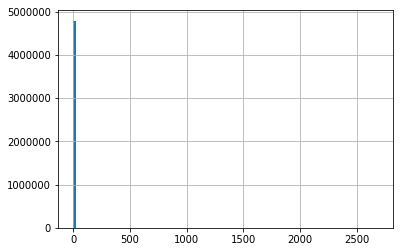

In [10]:
all_questions.question1.value_counts().hist(bins=100)

In [9]:
# all_questions.question1.value_counts()

In [16]:
questions_freq_dict = all_questions.question1.value_counts().to_dict()

In [17]:
#4.7 million unique questions

len(questions_freq_dict),  len(df1)+len(df2)+len(df1_test)+len(df2_test)

(4789031, 5500172)

### Calculate total number of times a group is repeated

In [24]:
%%time


all_components = nx.connected_component_subgraphs(g)

group_id   = 1
question_group_count = {}
question_group_id = {}

for c in all_components:

    count = 0 
    
    for node in c.nodes():
        if questions_freq_dict.has_key(node):
#             print node,questions_freq_dict[node]
            count += questions_freq_dict[node]

    #update group count for that question        
    for node in c.nodes():
        question_group_count[node] = count 
        question_group_id[node] =  group_id 
        
    group_id += 1     
#     print 
#     print 'total count for group is: ', count
    
    
#     break

CPU times: user 4.92 s, sys: 8 ms, total: 4.92 s
Wall time: 4.92 s


In [19]:
# question_group_count

In [20]:
question_group_count[np.nan]=0


### Create Features

In [16]:
from tqdm import tqdm

In [18]:
def calculate_group_frequency_per_question(df):
    
    for index, row in tqdm(df.iterrows(), miniters=1000):
        if question_group_count.has_key(row.question1):
            df.ix[index,"q1_group_frequency"] = question_group_count[row.question1]
        else:
            df.ix[index,"q1_group_frequency"] = 0 


        if question_group_count.has_key(row.question2):
            df.ix[index,"q2_group_frequency"] = question_group_count[row.question2]
        else:
            df.ix[index,"q2_group_frequency"] = 0 


        
    return df    

In [21]:
def try_apply_dict(x,dict_to_apply):
    try:
        return dict_to_apply[x]
    except KeyError:
        return 0

In [25]:
def does_belong_to_same_group(x,dict_to_apply):
    try:
        return question_group_id[x.question1] == question_group_id[x.question2]
    except KeyError:
        return False

In [26]:
tr.head(1)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0


### Same group feature

In [27]:
tr['same_group'] = tr.apply(lambda x: does_belong_to_same_group(x,question_group_count) ,axis=1)

In [22]:
tr['same_group'].shape

(404290,)

In [28]:
test['same_group'] = test.apply(lambda x: does_belong_to_same_group(x,question_group_count) ,axis=1)


In [29]:
tr.corr()

,id,qid1,qid2,is_duplicate,same_group
id,1.000000,0.629373,0.641993,-0.008784,-0.008903
qid1,0.629373,1.000000,0.700140,-0.247072,-0.247451
qid2,0.641993,0.700140,1.000000,-0.260101,-0.260498
is_duplicate,-0.008784,-0.247072,-0.260101,1.000000,0.999437
same_group,-0.008903,-0.247451,-0.260498,0.999437,1.000000


In [30]:
tr.to_csv("data/same_group_train.csv",index=False)

In [31]:
test.to_csv("data/same_group_test.csv",index=False)

In [32]:
same_group_test = pd.read_csv("data/same_group_test.csv")

In [33]:
same_group_test[same_group_test.same_group>0]

,test_id,question1,question2,same_group
19211,19211,How can I become rich?,How do I get rich?,True
214702,214702,How can I become rich?,What's the best way to become rich?,True
237179,237179,How can I become rich?,How can one get insanely rich?,True
440814,440814,How can I become rich?,Let's cut out the crap. How can somebody reall...,True
495790,495790,What are some of the best programming blogs?,What are the best programming blogs?,True
761777,761777,What are the best movies of Hollywood?,What are best Hollywood movies?,True
771857,771857,How can I become rich?,How could I get rich?,True
794430,794430,How Can I immigrate in Canada?,How do you immigrate to Canada with your family?,True
808426,808426,How could I get rich?,How can I become rich?,True
939135,939135,Does luck exist?,Does luck exist?,True


### group count feature

In [27]:
%%time
updated_tr = calculate_group_frequency_per_question(tr)

404290it [15:08, 444.93it/s]

CPU times: user 15min 8s, sys: 116 ms, total: 15min 9s
Wall time: 15min 8s


In [36]:
updated_tr.iloc[22]

id                                                                 22
qid1                                                               45
qid2                                                               46
question1             What are the questions should not ask on Quora?
question2                       Which question should I ask on Quora?
is_duplicate                                                        0
q1_group_frequency                                                  7
q2_group_frequency                                                 28
Name: 22, dtype: object

In [32]:
updated_tr.to_csv("data/training_with_group_freq.csv",index=False,encoding='utf-8')

In [75]:
group_freq_train = pd.read_csv("data/training_with_group_freq.csv")


In [25]:
# updated_test = calculate_group_frequency_per_question(test)

In [22]:
len(test)

2345796

In [26]:
%%time 

test["q1_group_frequency"] = test['question1'].map(lambda x: try_apply_dict(x,question_group_count))

CPU times: user 4.26 s, sys: 80 ms, total: 4.34 s
Wall time: 4.18 s


In [28]:
test.q1_group_frequency.isnull().sum()

0

In [29]:
test["q2_group_frequency"] = test['question2'].map(lambda x: try_apply_dict(x,question_group_count))

In [ ]:
test.to_csv("data/test_with_group_freq.csv",index=False,encoding='utf-8')

In [33]:
test.ix[1200:1259]

,test_id,question1,question2,q1_group_frequency,q2_group_frequency
1200,1200,How do I like chronic balanitis without using ...,How do being I treat persistent Balanitis with...,0,0
1201,1201,What is the song meaning of Hotel old California?,Do you like the song named what's California? ...,0,0
1202,1202,What do you think about Hitler? Was he good on...,Was Hitler a her or a good person?,0,0
1203,1203,What are examples of electrical herself energy...,What is electrical energy? are some examples?,0,0
1204,1204,What are the Dr recommended I skip a dose of 4...,What are your thoughts about the way attractiv...,0,0
1205,1205,How do you determine the shouldn Lewis structu...,How can the Structure for COF2 be determined?,0,0
1206,1206,How can I get rid of the smell of weed from fe...,How do yourself you get rid of and what causes...,0,0
1207,1207,Does Ariana Grande write did her own songs? Wh...,If Beyoncé in writing her songs?,0,0
1208,1208,How do thickened cream and whipping mechatroni...,How are whipped some and whipping cream differ...,0,0
1209,1209,What are the main benefits of an early 30s ind...,What is an IGL diamond weed certification?,0,0


In [17]:
group_freq = pd.read_csv("data/test_with_group_freq.csv")
q_freq = pd.read_csv("data/question_frequency_test.csv")

In [52]:
#1224

qid = 1250
q_freq.ix[qid]

id           1250
q1_hash    538565
q2_hash    361647
q1_freq         4
q2_freq         4
Name: 1250, dtype: int64

In [66]:
sample = group_freq.ix[qid].question2
sample

'What should be the smart strategy to prepare for RBI grade B exam?'

In [67]:
questions_freq_dict[sample]

4

In [68]:
group_freq.ix[qid]

test_id                                                            1250
question1             What is the correct strategy to prepare for RB...
question2             What should be the smart strategy to prepare f...
q1_group_frequency                                                    0
q2_group_frequency                                                   23
Name: 1250, dtype: object

In [71]:
tr[(tr.question1 == sample ) | ( tr.question2 == sample) ]

,id,qid1,qid2,question1,question2,is_duplicate
105868,105868,73190,174489,What are suggested books for RBI grade B exam?,What should be the smart strategy to prepare f...,1
175444,175444,73189,174489,What is a strategy to crack the RBI Grade B exam?,What should be the smart strategy to prepare f...,1
194936,194936,83694,174489,What shoud be strategy to crack RBI Grade B 2016?,What should be the smart strategy to prepare f...,1


In [72]:
test[(test.question1 == sample ) | ( test.question2 == sample) ]

,test_id,question1,question2
1250,1250,What is the correct strategy to prepare for RB...,What should be the smart strategy to prepare f...


##### checking if the q2_group_frequency makes sense

In [74]:
all_components = nx.connected_component_subgraphs(g)

i   = 0
question_group_count = {}


for c in all_components:

    count = 0 
    
    for node in c.nodes():
        if questions_freq_dict.has_key(node):
#             print node,questions_freq_dict[node]
            count += questions_freq_dict[node]

    #update group count for that question        
    for node in c.nodes():
        question_group_count[node] = count 
        
    if sample in c.nodes():
        for node in c.nodes():
            if questions_freq_dict.has_key(node): 
                print node, questions_freq_dict[node]
        

What are suggested books for RBI grade B exam? 4
What is a strategy to crack the RBI Grade B exam? 11
What should be the smart strategy to prepare for RBI grade B exam? 4
What shoud be strategy to crack RBI Grade B 2016? 4


### double checking TRAINING group frequencies 

In [79]:
group_freq_train.ix[1920:1930]

,id,qid1,qid2,question1,question2,is_duplicate,q1_group_frequency,q2_group_frequency
1920,1920,3821,3822,How do I open a SnapChat message without the o...,How do I delete messages on snapchat that the ...,0,0.0,0.0
1921,1921,3823,3824,What are the best value Michelin-starred resta...,What are the best Greek restaurants in NYC?,0,0.0,0.0
1922,1922,3825,3826,How can you find what your cell phone number is?,How do I find my cell phone number?,1,8.0,8.0
1923,1923,3827,3828,Given that alpha and beta are roots of the equ...,The roots of the equation [math]x^2+3x-10=0[/m...,0,0.0,0.0
1924,1924,3829,3830,How will the ban on Rs 500 and 1000 notes impa...,How does the ban on 500/1000 denominations aff...,1,1326.0,1326.0
1925,1925,3831,3832,Why has Malaysia failed to develop into a firs...,How did Malaysia become a developed country be...,0,0.0,0.0
1926,1926,3833,3834,"Who are Jains before conversion? Brahmins, Ksh...",Can a Shudra read Vedas?,0,0.0,0.0
1927,1927,3835,3836,Why is Vermont so liberal?,Is there any culture in Vermont?,0,0.0,0.0
1928,1928,3837,3838,Will you continue to do a thing that you think...,Renting a apt in bankruptcy?,0,0.0,0.0
1929,1929,3839,3840,How do we live a meaningful life?,How do I lead a meaningful life?,1,7.0,7.0


In [82]:
q_freq = pd.read_csv("data/question_frequency_train.csv")

qid = 1924
q_freq.ix[qid]

id               1924
q1_hash          1917
q2_hash         47008
q1_freq            46
q2_freq             9
is_duplicate        1
Name: 1924, dtype: int64

In [85]:
sample = group_freq_train.ix[qid].question1
sample

'How will the ban on Rs 500 and 1000 notes impact the Indian economy?'

In [86]:
questions_freq_dict[sample]

46

In [90]:
group_freq_train.ix[qid]

id                                                                 1924
qid1                                                               3829
qid2                                                               3830
question1             How will the ban on Rs 500 and 1000 notes impa...
question2             How does the ban on 500/1000 denominations aff...
is_duplicate                                                          1
q1_group_frequency                                                 1326
q2_group_frequency                                                 1326
Name: 1924, dtype: object

In [93]:
tr[(tr.question1 == sample ) | ( tr.question2 == sample) ].shape, test[(test.question1 == sample ) | ( test.question2 == sample) ].shape

((35, 6), (11, 3))

In [95]:
all_components = nx.connected_component_subgraphs(g)

i   = 0
question_group_count = {}


for c in all_components:

    count = 0 
    
    for node in c.nodes():
        if questions_freq_dict.has_key(node):
#             print node,questions_freq_dict[node]
            count += questions_freq_dict[node]

    #update group count for that question        
    for node in c.nodes():
        question_group_count[node] = count 
        
    if sample in c.nodes():
        for node in c.nodes():
            if questions_freq_dict.has_key(node): 
                print node, questions_freq_dict[node]
                
        print count       

Modi's announcement on banning 500 and 1000 currency notes. How would it affect economy? 28
Will the currency ban in India affect the economy? 12
What will be the consequences of 500 and 1000 rupee notes banning? 33
What are the repercussions of 500 and 1000 rupee notes not being legal tender anymore? 29
What is the use of banning 500 and 1000 rupee notes and introducing new 500 and 2000 rupee notes? 37
How is banning 500 and 1000 INR going to help Indian economy? 36
What will be the impact of the step taken to ban the 500 & 1000 rupee note on Indian economy? 24
How will the ban on Rs. 1000 and Rs. 500 notes impact Indian economy? 34
How Indian economy got affected after ban of 500 1000 notes? 31
How will our economy will be affected by demonetizing Rs 500 and Rs 1000 notes? 24
What drastic changes can take place in Indian economy owing to ban on 500₹ and 1000₹ notes? 2
What will be the effects after banning on 500 and 1000 rupee notes? 28
How will ban on 500 and 1000 rupees note affec